# Analyze A/B Test Results 

This project will assure you have mastered the subjects covered in the statistics lessons. We have organized the current notebook into the following sections: 

- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
 
 
<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, we will be working to understand the results of an A/B test run by an e-commerce website.  My goal is to work through this notebook to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.





<a id='probability'></a>
## Part I - Probability

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

Now, read in the `ab_data.csv` data. Store it in `df`. Below is the description of the data, there are a total of 5 columns:

<center>

|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|timestamp|Time stamp when the user visited the webpage|-|
|group|In the current A/B experiment, the users are categorized into two broad groups. <br>The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. <br>However, **some inaccurate rows** are present in the initial data, such as a `control` group user is matched with a `new_page`. |`['control', 'treatment']`|
|landing_page|It denotes whether the user visited the old or new webpage.|`['old_page', 'new_page']`|
|converted|It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.|`[0, 1]`|
</center>


**a.** Read the dataset from the `ab_data.csv` file and take a look at the top few rows here:

In [ ]:
df = pd.read_csv('ab_data.csv')

In [4]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


**b.** Find the number of rows in the dataset.

In [5]:
df.shape

(294478, 5)

**c.** The number of unique users in the dataset.

In [6]:
df['user_id'].nunique()

290584

**d.** The proportion of users converted.

In [7]:
df['converted'].mean()

0.11965919355605512

**e.** The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [8]:
df[((df['group']=='treatment') & (df['landing_page'] !='new_page')) | ((df['group']=='control') & (df['landing_page'] !='old_page')) ].count()[0]

3893

**f.** Do any of the rows have missing values?

In [9]:
df.isnull().sum().any()

False

In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`. 

However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old wepage.  

In [10]:
# Remove the inaccurate rows, and store the result in a new dataframe df2
df.drop(df[((df['group']=='treatment') & (df['landing_page'] !='new_page')) | ((df['group']=='control') & (df['landing_page'] !='old_page')) ].index,inplace=True)
df2 = df

In [11]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

**a.** How many unique **user_id**s are in **df2**?

In [12]:
df2['user_id'].nunique()

290584

**b.** There is one **user_id** repeated in **df2**.  What is it?

In [13]:
df2[df2['user_id'].duplicated()]['user_id']

2893    773192
Name: user_id, dtype: int64

**c.** Display the rows for the duplicate **user_id**? 

In [14]:
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**d.** Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [15]:
# Remove one of the rows with a duplicate user_id..
# Hint: The dataframe.drop_duplicates() may not work in this case because the rows with duplicate user_id are not entirely identical. 
df2.drop(df2[df2['user_id'].duplicated()].index, inplace=True)
# Check again if the row with a duplicate user_id is deleted or not
df2[df2['user_id'].duplicated()]['user_id']

Series([], Name: user_id, dtype: int64)


**a.** What is the probability of an individual converting regardless of the page they receive?<br><br>





In [16]:
p_pop = df2['converted'].mean()
p_pop

0.11959708724499628

**b.** Given that an individual was in the `control` group, what is the probability they converted?

In [17]:
control_c = df2.query('group == "control"')['converted'].mean()
control_c

0.1203863045004612

**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

In [18]:
experiment_c = df2.query('group == "treatment"')['converted'].mean()
experiment_c

0.11880806551510564

In [19]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff = control_c - experiment_c
obs_diff

0.0015782389853555567

**d.** What is the probability that an individual received the new page?

In [20]:
df2.query('landing_page == "new_page"')['user_id'].shape[0] /df2['user_id'].shape[0]


0.5000619442226688

**e.** Consider your results from parts (a) through (d) above, and explain below whether the new `treatment` group users lead to more conversions.

>**No the old page still have a highr lead more conversions**

<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, you could run a hypothesis test continuously as long as you observe the events. 

However, then the hard questions would be: 
- Do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do you run to render a decision that neither page is better than another?   

If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should be your null and alternative hypotheses (**$H_0$** and **$H_1$**)?  

We can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the "converted" probability (or rate) for the old and new pages respectively.

> $$ H_0: p_{new} - p_{old} \leq  0 $$
> $$ H_1: p_{new} - p_{old} >  0 $$

### Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>

$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section, we will: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 


**a.** What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

In [21]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [22]:
p_old = df2['converted'].mean()
p_old

0.11959708724499628

**c.** What is $n_{new}$, the number of individuals in the treatment group? <br><br>

In [23]:
n_new = df2.query('group == "treatment" and landing_page == "new_page"')['user_id'].count()
n_new

145310

**d.** What is $n_{old}$, the number of individuals in the control group?

In [24]:
n_old = df2.query('group == "control" and landing_page == "old_page"')['user_id'].count()
n_old

145274

**e. Simulate Sample for the `treatment` Group**<br> 
Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  <br>
Store these $n_{new}$ 1's and 0's in the `new_page_converted` numpy array.

In [25]:
# Simulate a Sample for the treatment Group
new_page_converted = np.random.choice([0,1], n_new)

**f. Simulate Sample for the `control` Group** <br>
Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br> Store these $n_{old}$ 1's and 0's in the `old_page_converted` numpy array.

In [26]:
# Simulate a Sample for the control Group
old_page_converted = np.random.choice([0,1], n_old)

**g.** Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for your simulated samples from the parts (e) and (f) above. 

In [27]:
new_page_converted.mean() - old_page_converted.mean()

0.0039571272459654194


**h. Sampling distribution** <br>
Re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process you used in parts (a) through (g) above. 

<br>

Store all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [28]:
# Sampling distribution
p_diffs = []
size = df2.size
for _ in range(10000):
    new_page_converted = np.random.choice([0,1], size)
    old_page_converted = np.random.choice([0,1], size)
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean()) 

**i. Histogram**<br> 
Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  <br><br>

Also, use `plt.axvline()` method to mark the actual difference observed  in the `df2` data (recall `obs_diff`), in the chart.  

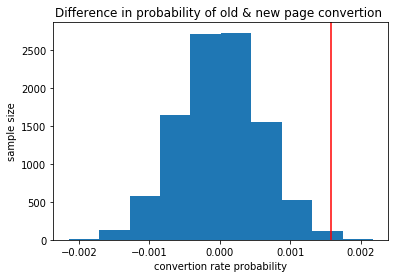

In [31]:
plt.hist(p_diffs)
plt.title('Difference in probability of old & new page convertion ')
plt.xlabel('convertion rate probability')
plt.ylabel('sample size')
plt.axvline(obs_diff,c='red');

**j.** What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

In [32]:
(p_diffs > obs_diff).mean()

0.0030000000000000001

**k.** Please explain in words what we 
have just computed in part **j** above.  
 - What is this value called in scientific studies?  
 - What does this value signify in terms of whether or not there is a difference between the new and old pages?

- A p-value
- small p-values suggest our null is not true. Rather, our statistic is likely to have come from a different distribution than the null. That's mean our alternative is true and the new page is lead more conversions. When the p-value is large, we have evidence that our statistic was likely to come from the null hypothesis. In other words there is no difference between the new and old pages or the old is better.
- In this case we have a small p-value suggest our null is not true then we reject the null



**l. Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

Fill in the statements below to calculate the:
- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page


In [33]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = df2.query('landing_page == "old_page" and converted == "1"')['converted'].count()

# number of conversions with the new_page
convert_new = df2.query('landing_page == "new_page"and converted == "1"')['converted'].count()

# number of individuals who were shown the old_page
n_old = df2.query('landing_page == "old_page"')['user_id'].count()

# number of individuals who received new_page
n_new = df2.query('landing_page == "new_page"')['user_id'].count()

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


**m.** Now use `sm.stats.proportions_ztest()` to compute your test statistic and p-value. 

The syntax is: 
```bash
proportions_ztest(count_array, nobs_array, alternative='larger')
```
where, 
- `count_array` = represents the number of "converted" for each group
- `nobs_array` = represents the total number of observations (rows) in each group
- `alternative` = choose one of the values from `[‘two-sided’, ‘smaller’, ‘larger’]` depending upon two-tailed, left-tailed, or right-tailed respectively. 

The built-in function above will return the z_score, p_value. 

---
### About the two-sample z-test
Recall that you have plotted a distribution `p_diffs` representing the
difference in the "converted" probability  $(p{'}_{new}-p{'}_{old})$  for your two simulated samples 10,000 times. 

Another way for comparing the mean of two independent and normal distribution is a **two-sample z-test**. You can perform the Z-test to calculate the Z_score, as shown in the equation below:

$$
Z_{score} = \frac{ (p{'}_{new}-p{'}_{old}) - (p_{new}  -  p_{old})}{ \sqrt{ \frac{\sigma^{2}_{new} }{n_{new}} + \frac{\sigma^{2}_{old} }{n_{old}}  } }
$$

where,
- $p{'}$ is the "converted" success rate in the sample
- $p_{new}$ and $p_{old}$ are the "converted" success rate for the two groups in the population. 
- $\sigma_{new}$ and $\sigma_{new}$ are the standard deviation for the two groups in the population. 
- $n_{new}$ and $n_{old}$ represent the size of the two groups or samples (it's same in our case)


>Z-test is performed when the sample size is large, and the population variance is known. The z-score represents the distance between the two "converted" success rates in terms of the standard error. 

Next step is to make a decision to reject or fail to reject the null hypothesis based on comparing these two values: 
- $Z_{score}$
- $Z_{\alpha}$ or $Z_{0.05}$, also known as critical value at 95% confidence interval.  $Z_{0.05}$ is 1.645 for one-tailed tests,  and 1.960 for two-tailed test. You can determine the $Z_{\alpha}$ from the z-table manually. 

Decide if your hypothesis is either a two-tailed, left-tailed, or right-tailed test. Accordingly, reject OR fail to reject the  null based on the comparison between $Z_{score}$ and $Z_{\alpha}$. We determine whether or not the $Z_{score}$ lies in the "rejection region" in the distribution. In other words, a "rejection region" is an interval where the null hypothesis is rejected iff the $Z_{score}$ lies in that region.


In [34]:
import statsmodels.api as sm
# ToDo: Complete the sm.stats.proportions_ztest() method arguments
z_score, p_value = sm.stats.proportions_ztest([convert_old,convert_new], [n_old,n_new], alternative='larger')
print(z_score, p_value)

1.31092419842 0.094941687241


**n.** What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?<br><br>

>**Z-score tells us how many standard deviations above the mean in this case 1.31. With 1.31 z-score is smaller than critical value and 0.094 associated with p-value similar to we calculated before we fail to reject the null.**

<a id='regression'></a>
### Part III - A regression approach


In this final part, we will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

**a.** Since each row in the `df2` data is either a conversion or no conversion, what type of regression should you be performing in this case?

>**Logistic Regression.**

**b.** The goal is to use **statsmodels** library to fit the regression model you specified in part **a.** above to see if there is a significant difference in conversion based on the page-type a customer receives. However, you first need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [35]:
df2['intercept'] = 1
df2[['not_ab_page','ab_page']] = pd.get_dummies(df2['group'])
df2 = df2.drop('not_ab_page',axis =1)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


**c.** Use **statsmodels** to instantiate your regression model on the two columns you created in part (b). above, then fit the model to predict whether or not an individual converts. 


In [36]:
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


**d.** Provide the summary of your model below, and use it as necessary to answer the following questions.

In [37]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2023-02-22 07:29 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

**e.** What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  


>**The p-value associated with ab_page is 0.1899 which is not so differnt from we calculated before.It does not present as statistically significant to perdict the impcat on conversion.**

**f.** Now, we are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

>**It's a good idea to consider other factors and see the impact on conversion because ab_page is not significant enough to impact on conversion.**

**g. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 

In [38]:
# Read the countries.csv
df3 = pd.read_csv('countries.csv')

In [39]:
# Join with the df2 dataframe
df_merged = df2.set_index('user_id').join(df3.set_index('user_id'))

In [40]:
# Create the necessary dummy variables
df_merged[['US','UK','CA']]= pd.get_dummies(df_merged['country'])

In [41]:
df_merged['country'].value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

**h. Fit your model and obtain the results**<br> 
Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if are there significant effects on conversion. 


In [42]:
# Fit your model, and summarize the results
logit_mod = sm.Logit(df_merged['converted'], df_merged[['intercept','US', 'UK']])
results = logit_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2023-02-22 07:29 AIC:              212780.8333
No. Observations:   290584           BIC:              212812.5723
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9967    0.0068  -292.3145  0.0000  -2.0101  -1.9833
US           -0.0408    0.0269    -1.5178  0.1291  -0.0935   0.0119
UK            0.0099    0.0133     0.7458  0.4558  -0.0161   0.0360
==================================================================

"""

>**The p-value of us & uk does not present as statistically significant. So we fail to reject the null. Also the
effect of ab_page and country is not significant enough to impact on conversion.**

In [43]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0